In [1]:
%matplotlib inline
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import os
import rasterio.plot 
import datetime
import numpy as np
from shapely.geometry import mapping
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib import cm as CM
from shapely.geometry import box

In [2]:
# os.chdir("..")
cwd = os.getcwd()
print(cwd)

/media/daniel/Respaldo/Memoria/AraucoNursery


In [3]:
url_imagen_dron = "PROYECTOS/CONTEO_SATELITE/imagenes/corte_pequeño_dron.tif"
url_imagen_1m = "PROYECTOS/CONTEO_SATELITE/imagenes/corte_pequeño_1m.tif"
url_imagen_3m = "PROYECTOS/CONTEO_SATELITE/imagenes/corte_pequeño_3m.tif"
url_imagen_10m = "PROYECTOS/CONTEO_SATELITE/imagenes/corte_pequeño_10m.tif"
url_corte_rodal = "PROYECTOS/CONTEO_SATELITE/rodales/40050_pira_2017_rodal.shp"
url_imagen_shape = "PROYECTOS/CONTEO_SATELITE/mascaras/previo_shape.tif"

url_mascaras = "PROYECTOS/CONTEO_SATELITE/mascaras/mascara_rodal_esri_clip.shp"
rotados = "PROYECTOS/CONTEO_SATELITE/puntos_cortados.shp"
corte = "PROYECTOS/CONTEO_SATELITE/corte_pequeño.shp"
url_salida = "train/"+str(datetime.datetime.now().day)+"/"
url_salida_png = url_salida+"/png/"
# url_salida_png_1 = "train/"+str(datetime.datetime.now().day)+"/png_1m/"
url_salida_tiff = url_salida+"/tiff/"
url_salida_shp = url_salida+"/shp/"
archivo_h5_cuentas = url_salida+'/data_cuentas.h5'
archivo_h5_mapa = url_salida+'/data_mapa.h5'
carpeta_imagenes = "imagenes_diapo/"

In [4]:
carpetas = [url_salida,url_salida_png,url_salida_tiff,url_salida_shp]
for element in carpetas:
    if not os.path.exists(element):
        os.makedirs(element)

In [5]:
shapefile = gpd.read_file(url_mascaras)
# puntos = gpd.read_file(rotados)
rodal = gpd.read_file(url_corte_rodal)
mascaras = rasterio.open(url_imagen_shape)
raster= rasterio.open(url_imagen_1m)
# raster= rasterio.open(url_imagen_dron)

In [6]:
mascaras.shape,raster.shape

((24565, 24265), (569, 997))

In [7]:
rodal = rodal.rotate(48.01,origin=(761774.565,5881886.945))
# rodal.to_file(driver = 'ESRI Shapefile', filename = "rodal_rotado")

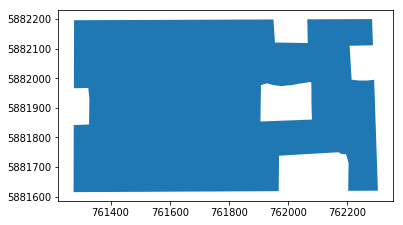

In [8]:
rodal.plot()
plt.savefig(carpeta_imagenes + "rodal_rotado")

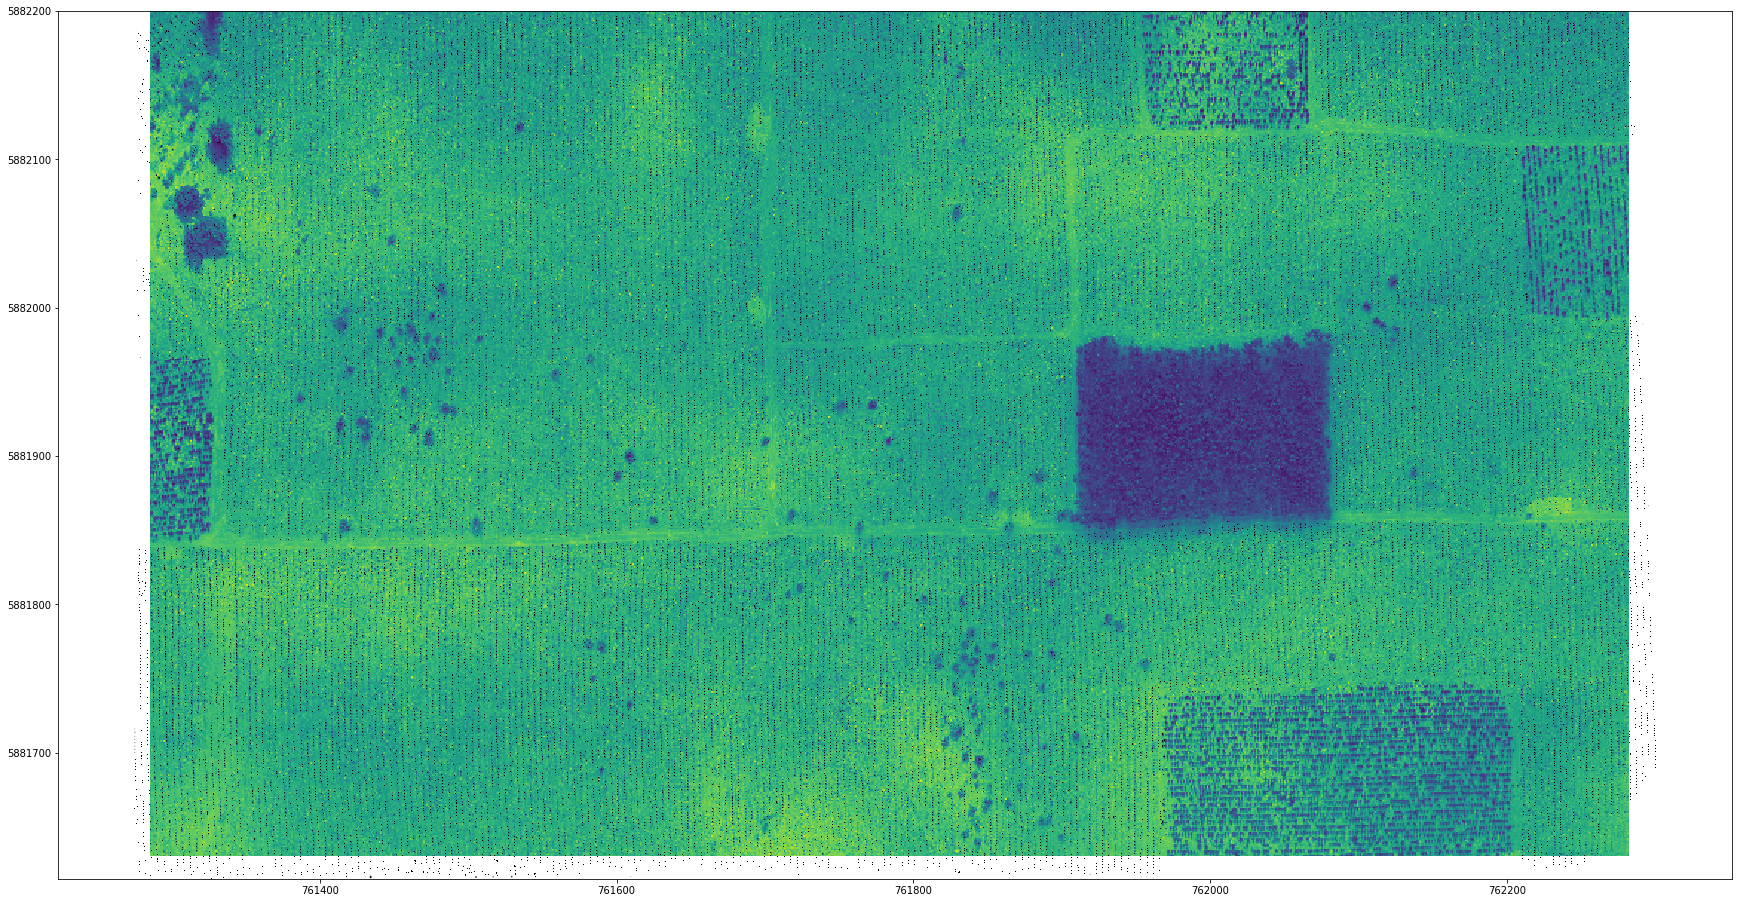

In [10]:
fig, ax = plt.subplots(figsize=(30,30))
rasterio.plot.show(raster, ax=ax)
shapefile.plot(facecolor="black",ax=ax)
plt.savefig(carpeta_imagenes +"mapa_puntos_superpuestos")

In [11]:
def extract_poly_coords(geom):
    total = []
    if geom.type == 'Polygon':
        exterior_coords = geom.exterior.coords[:]
        interior_coords = []
        for interior in geom.interiors:
            interior_coords += interior.coords[:]
    elif geom.type == 'MultiPolygon':
        exterior_coords = []
        interior_coords = []
        for part in geom:
            epc = extract_poly_coords(part)  # Recursive call
            exterior_coords += epc['exterior_coords']
            interior_coords += epc['interior_coords']
    else:
        raise ValueError('Unhandled geometry type: ' + repr(geom.type))
    for element in exterior_coords:
        total.append(element)
    for element in interior_coords:
        total.append(element)
    return total

In [14]:
def obtencion_pixeles_exteriores(raster,shapefile,rodal= None):##sacamos los pixeles donde 
    import shapely
    #bounding box del raster
    #si esque tenemos un shapefile cortamos de acuerdo al shapefile
    if(rodal):
        pass
#         rodal.bounds
        
    #cortamos los puntos de acuerdo al raster    
    r = raster.bounds
    bbox = box(r[0], r[1], r[2], r[3])
    interseccion = shapefile.intersects(bbox)
    shapefile = shapefile[interseccion]
    print(type(shapefile))
    # obtenemos los valores de las geometrias en una lista
    geoms = shapefile.geometry.values
    arboles_totales = []
    for element in geoms:
    
        if(isinstance(element, shapely.geometry.polygon.Polygon)):
#         print(element)
        #guardamos lista de las coordenadas
#         print(len(element.interior.coords.xy[0]))
            coordenadas = extract_poly_coords(element)
            
    
#             coordenadas = list(zip(element.exterior.coords.xy[0],element.exterior.coords.xy[1]))
            #guardamos las coordenadas del arbol
            arbol = []
            for coord in coordenadas:
                x,y = raster.index(coord[0],coord[1])
                
                arbol.append((x-1,y-1))
            arbol = list(set(arbol))
            arboles_totales.append(arbol)
    return arboles_totales

In [15]:
arboles_totales = obtencion_pixeles_exteriores(raster,shapefile)

<class 'geopandas.geodataframe.GeoDataFrame'>


In [16]:
def generar_mapa_probabilidad(raster,arboles):
    pos = np.zeros((raster.height,raster.width,))
    for ptos_arbol in arboles_totales:
        total = len(ptos_arbol)
        for element in ptos_arbol:
            if(element[0] < raster.height and element[1] < raster.width):
                pos[element[0],element[1]] += (1/total)
            #             if(element[0] < raster.height and element[1] < raster.width):

    return pos

In [17]:
mapa = generar_mapa_probabilidad(raster,arboles_totales)

In [18]:
r = raster.bounds
bbox = box(r[0], r[1], r[2], r[3])
interseccion = shapefile.intersects(bbox)
shapefile = shapefile[interseccion]
shapefile.shape[0]- np.sum(mapa)

5.0

In [19]:
# unicos,cuentas = np.unique(mapa,return_counts = True) 
# for element in list(zip(unicos,cuentas)):
#     print(element)
# # print(np.sum(list(zip(unicos,cuentas),axis=1)))

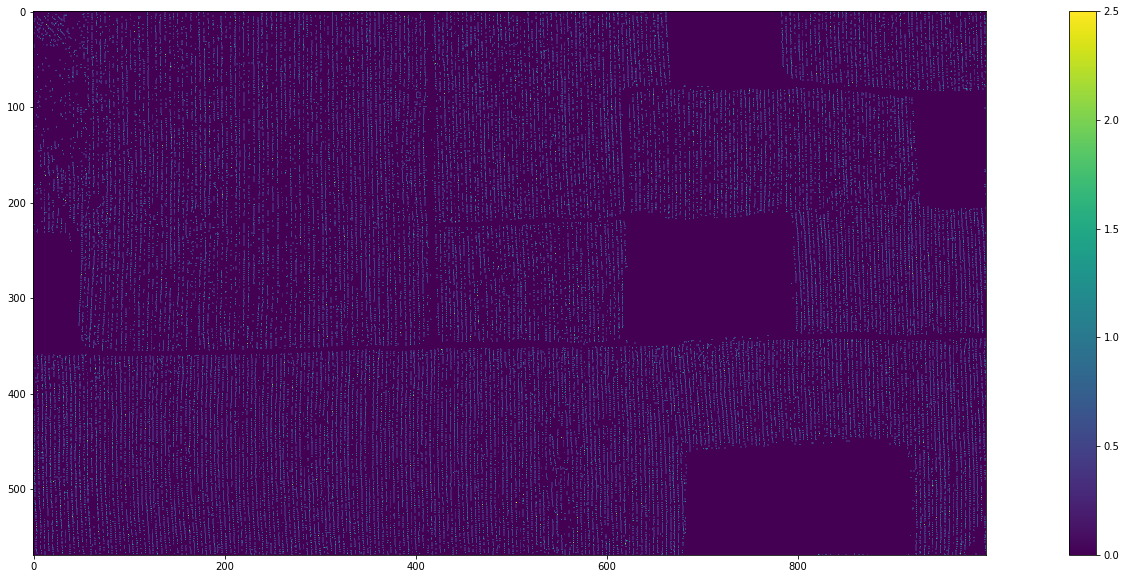

In [20]:
fig, ax = plt.subplots(figsize=(30,10))
# rasterio.plot.show(raster, ax=ax)
plt.imshow(mapa)
plt.colorbar()
plt.savefig("mapa_puntos_superpuestos_esri")

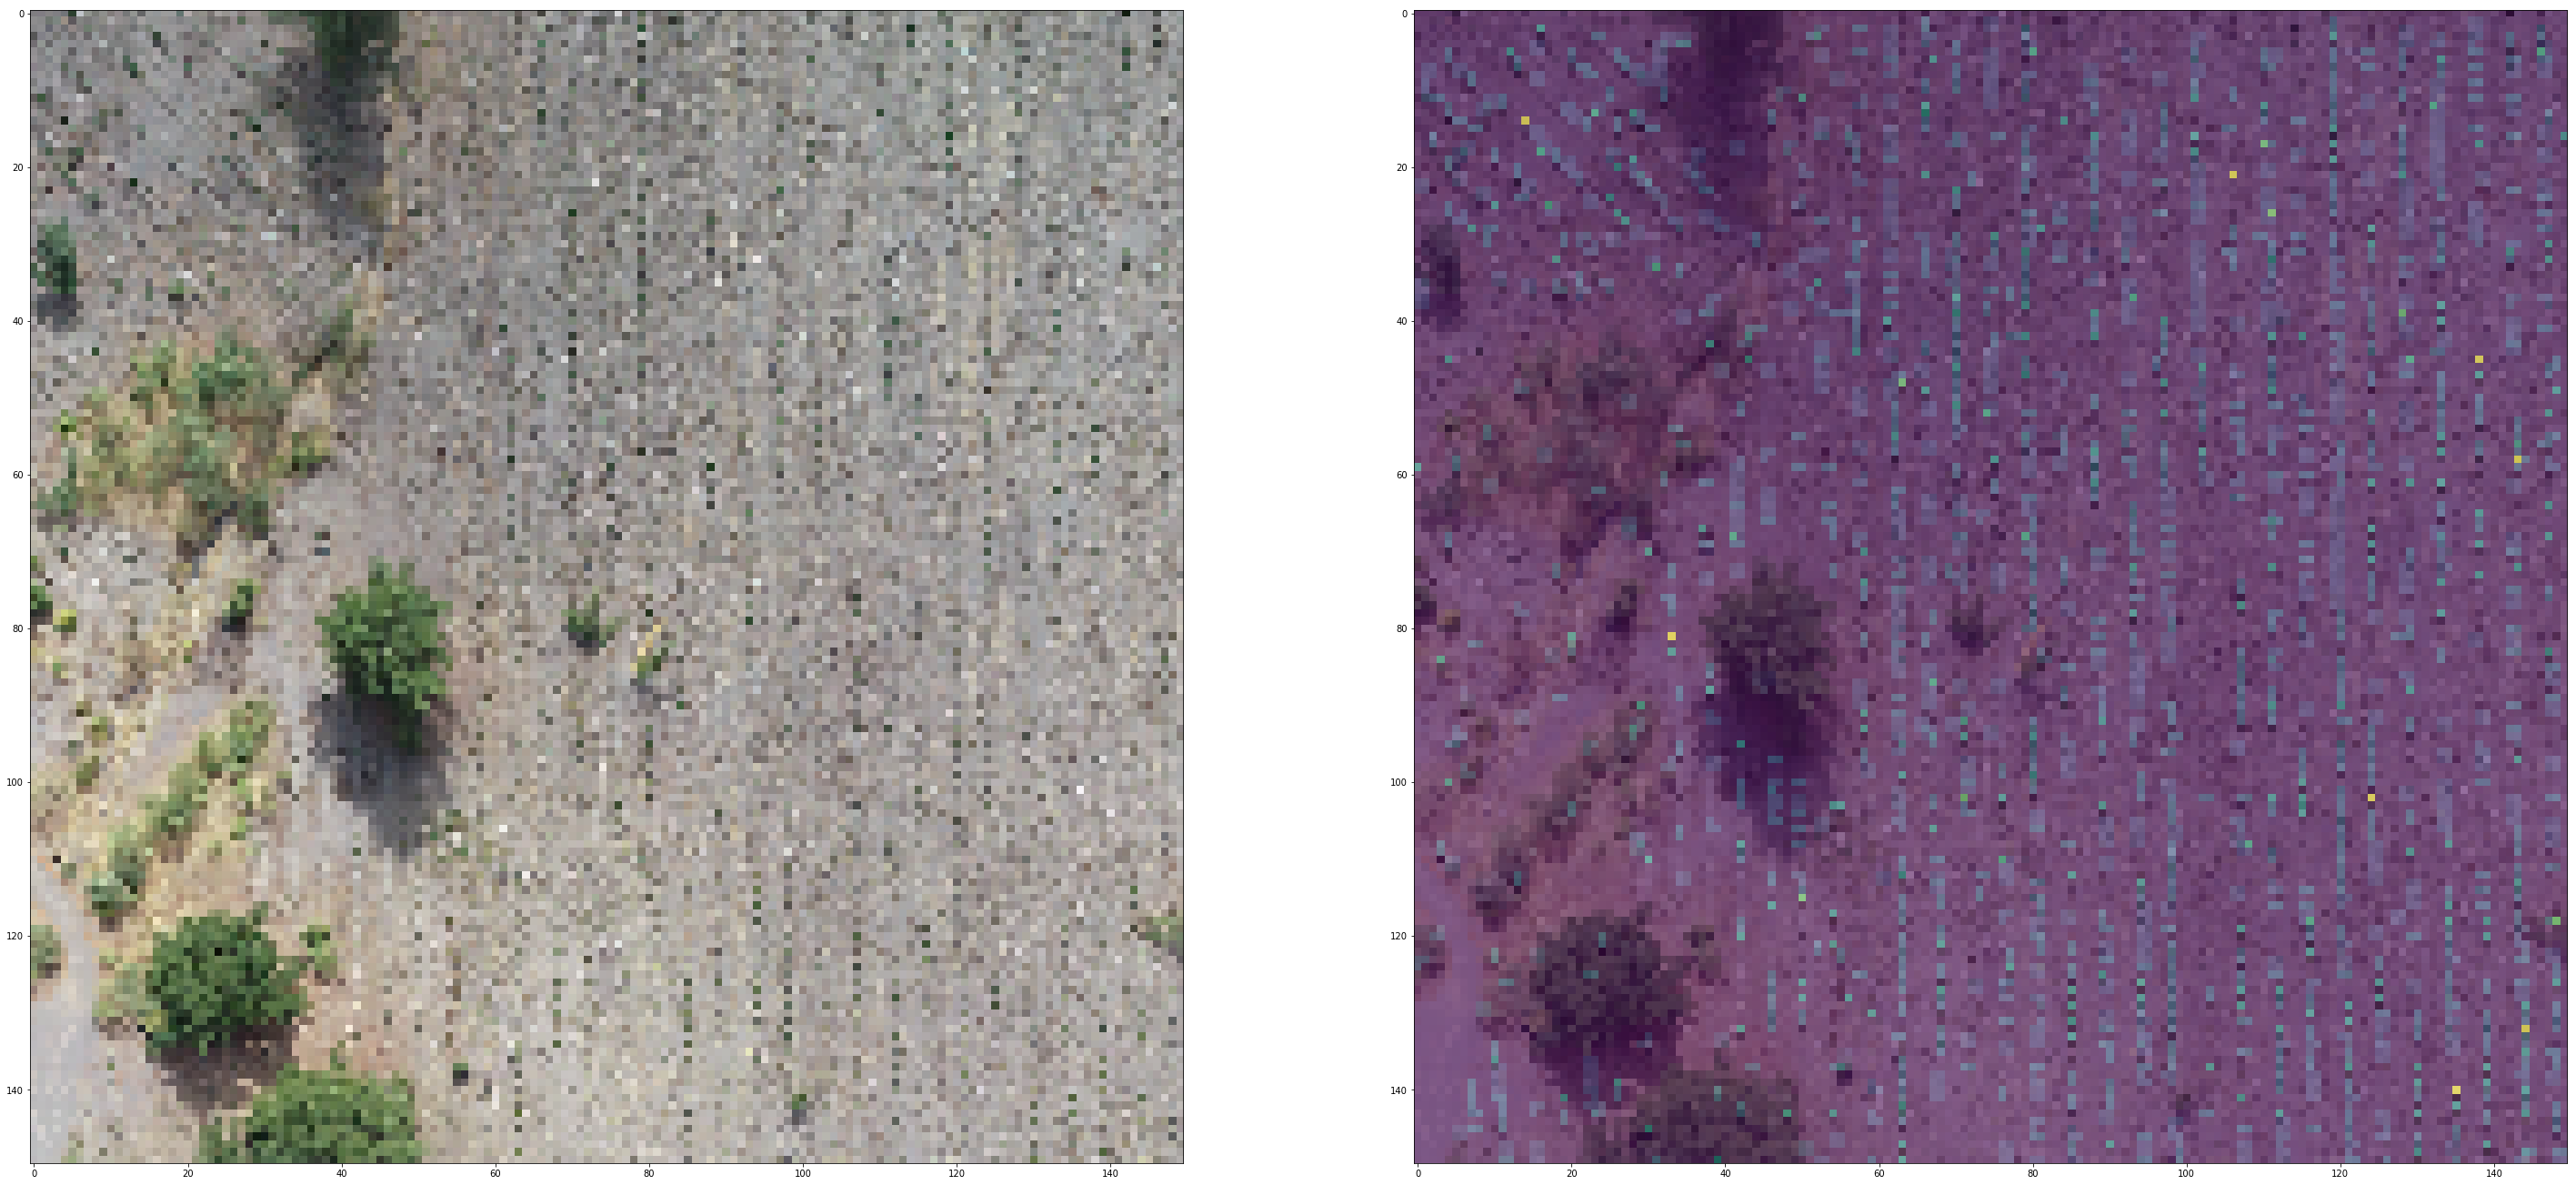

In [21]:
step = 10
width = 150
height = 150
offsetX = 0
offsetY = 0
i=0
while (1 != i):
    i = i+ 1
        # finalizar si se a recorrido toda la imagen
    if(offsetY >= raster.height and offsetX >= raster.width):
        break
     #cuando llegue al borde en el eje x, debo bajar(sumar en eje y) y debo volver a empezar setear offsetX en 0 y widthX en 100
    elif(offsetX >= raster.width):
        offsetY = offsetY + step
        offsetX = 0
        
    #entregamos los pixeles para obtener las coordenadas
    t = raster.xy(offsetX, offsetY)
    r = raster.xy(offsetX + width , offsetY)
    l = raster.xy(offsetX, offsetY + height)
    b = raster.xy(offsetX + width , offsetY + height)
    minx = min(t[0],l[0],b[0],t[0])
    maxx = max(t[0],l[0],b[0],t[0])
    miny = min(t[1],l[1],b[1],t[1])
    maxy = max(t[1],l[1],b[1],t[1])
    bbox = box(minx, miny, maxx, maxy)
    
#     pos = np.zeros((.raster.width,raster.heigth))
    pos = mapa[offsetX:width, offsetY:height]
    
    try:
        #transformacion de la imagen
        out_img, out_transform = mask(raster, shapes=[bbox], crop=True)
        out_png = out_img[0:3,0:width,1:height+1]
        #actual z,x,y
        #en caso den transponer
        out_png = np.transpose(out_png, (1, 2, 0))
       
        fig = plt.figure(figsize=(50,50))
        ax3= fig.add_subplot(1,2,1)
        plt.imshow(out_png)
        ax3= fig.add_subplot(1,2,2)
        plt.imshow(out_png)
        plt.imshow(pos, alpha=0.55)
        plt.savefig("interseccion")
    except:
        pass